# ADS Homework #3 - Answer Key
Monday 2-5pm Session, Proffessor Tim Savage

Please submit this assignment to the NYU Classes 'Assignments' section by 12:00pm on Monday, October 12, strictly labeling the assignments with the format **'ADS_HW3_(your net ID).ipynb'**. Be sure not to confuse Net ID (e.g. 'acs882') with N-number ('N166...'). This homework is here for you to better understand and practice the material; while you may discuss approaches to problems with your classmates (in fact, this is encouraged!), please ensure that all final code submitted is your own. You may reach out to the TA, Alex Shannon, at acs882@nyu.edu at anytime (he hangs out at CUSP a lot (Thursdays are a particularly good day to find him), so feel free to say hello). Additionally, Professor Savage will hold office hours at Silver Hall, in Room 410 on Mondays from 9am-12am. While plots are initially rendered in this notebook to guide you, please ensure that your code can recreate them (or something very similar), as all notebooks will be run before grading.

### Problem 1 - Return on University Education (20 points)

Please read the following article: https://promarket.org/learning-university-pay-off/

Consider Judea Pearl's idea of the ladder of causality that was discussed in class.  Describe whether or not the study described in the article meets the standard of (a) association; (b) intervention; and (c) counterfactual.

**(a)**

**(b)**

**(c)**

### Problem 2 - Markov Processes (40 points)

In class, we walked through an example of a rat moving between subway tracks. While any New Yorker knows that this is doubtlessly a very real urban example, in the real world, unless you have an oddly musophilic boss, you likely will be tasked with more human-centric analyses. Let's dig into an example of people moving throughout a subset of 5 Brooklyn Neighborhoods. 
<br><br>
Assumptions made here are that total population is static (i.e. no new entrants or people moving outside of this subset of neighborhoods), and that there's a 40% chance that people stay in their current neighborhood (which can be interpreted as either not moving or moving very close by) and a known probability of moving from one neighborhood to another (these are defined in the code below), with preference shown for bordering neighborhoods. 
<br><br>
We will load geo-data and filter to the specified Brooklyn neighborhoods. We will then examine movement between neighborhoods as a Markov Process, iterating until an equilibrium becomes apparent (hint: you should not see any absorbing states in this example), then visualize and interpret the results.

**Part 1**: Go through the below example, completing the code where marked. (30 points)

In [28]:
import imageio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
import time
from IPython.display import HTML

sns.set_style('white')
# filters to apply to the data
county = 'Kings'
hoods  = ['Downtown', 'DUMBO', 'Fort Greene', 'Boerum Hill', 'Clinton Hill']

def get_neighborhoods(file, county=county, neighborhoods=hoods):
    '''
    reads in geopandas file from Zillow, returns geodataframe with specified neighborhoods
    '''
    ny_gdf = gpd.read_file(file)
    ny_gdf = ny_gdf[(ny_gdf.County==county) & (ny_gdf.Name.isin(hoods))]
    
    # locate coordinate points to plot neighborhood names
    ny_gdf['coords'] = ny_gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
    ny_gdf['coords'] = [coords[0] for coords in ny_gdf['coords']]
    return ny_gdf

bk_neighborhoods = get_neighborhoods('../data/ZillowNeighborhoodsNY.shp')
bk_neighborhoods = bk_neighborhoods.sort_values('Name').reset_index(drop=True)
bk_neighborhoods

,State,County,City,Name,RegionID,geometry,coords
0,NY,Kings,New York,Boerum Hill,272994,POLYGON ((-73.98682489707035 40.68846655576456...,"(-73.9864896425407, 40.68600290969882)"
1,NY,Kings,New York,Clinton Hill,270815,"POLYGON ((-73.9619257224787 40.69778778197278,...","(-73.96455445229091, 40.689058350724)"
2,NY,Kings,New York,DUMBO,270841,POLYGON ((-73.98446723099994 40.70646091900005...,"(-73.99003960915954, 40.703545669500045)"
3,NY,Kings,New York,Downtown,270825,POLYGON ((-73.98697203810939 40.70105040762233...,"(-73.98678098579373, 40.693458468711725)"
4,NY,Kings,New York,Fort Greene,273766,POLYGON ((-73.98230754099966 40.70227250100029...,"(-73.97573066517539, 40.69136863239475)"


Above we can see the geodataframe. Now let's plot it: 

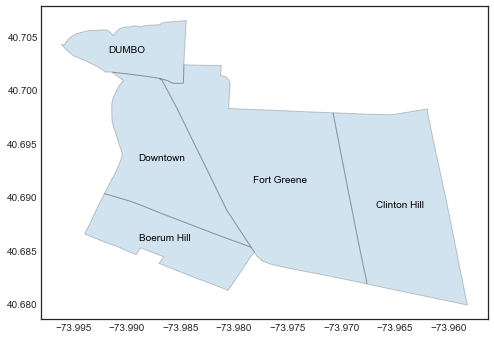

In [60]:
bk_neighborhoods.plot(figsize=(8, 6), edgecolor='black', alpha=0.2)

for idx, row in bk_neighborhoods.iterrows():
    plt.annotate(s=row['Name'], xy=row['coords'], color='Black', horizontalalignment='center', size=10)

Here, we define the likelihoods of moving from one neighborhood to another.
Use a Dirichlet Distrobution (convenient for generating samples that sum to 1.0) to obtain an initial starting population for the neighborhoods https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.random.dirichlet.html

In [62]:
np.random.seed(42)
data = np.matrix(np.random.dirichlet(np.ones(5),size=1)) # randomly assign pcts to each neighborhood
#data = # use a dirichlet distribution to create a 1-by-5 matrix of values that sum to 1.0
initial_vals = zip(list(bk_neighborhoods.Name), np.array(data)[0])

print('Initial allocations:')
print('--------------------')
for i, j in initial_vals:
    print('{:<13s} {:>5.2f}%'.format(i, round(j, 4)*100))
print('--------------------')
print()

move_likelihoods = np.matrix('0.4 0.1 0.1 0.2 0.2; 0.1 0.4 0.1 0.15 0.25; 0.1 0.1 0.4 0.2 0.2;' 
                             + '0.2 0.05 0.15 0.4 0.2; 0.15 0.2 0.05 0.2 0.4')
pd.DataFrame(data=move_likelihoods, index=bk_neighborhoods.Name, columns=bk_neighborhoods.Name) 
# we could use 'tabulate' here, as this is for visualization purposes, but a pd dataframe is 
# often just as clear and has more compatability with python environments

Initial allocations:
--------------------
Boerum Hill    7.98%
Clinton Hill  51.20%
DUMBO         22.40%
Downtown      15.53%
Fort Greene    2.89%
--------------------



Name,Boerum Hill,Clinton Hill,DUMBO,Downtown,Fort Greene
Name,,,,,
Boerum Hill,0.40,0.10,0.10,0.20,0.20
Clinton Hill,0.10,0.40,0.10,0.15,0.25
DUMBO,0.10,0.10,0.40,0.20,0.20
Downtown,0.20,0.05,0.15,0.40,0.20
Fort Greene,0.15,0.20,0.05,0.20,0.40


Here we will build a Markov process and visualize it in a GIF; this is useful for seeing equilibrium state reached over time. We will then look at the numbers to confirm what the plot is showing us. 

In [63]:
years = 7
pct_by_year = []

def plot_neighborhood_movement(years):

    pct_in_hood = data * np.linalg.matrix_power(move_likelihoods, years)
    bk_neighborhoods['pct_in_hood'] = np.array(pct_in_hood)[0]
    pct_by_year.append(np.array(pct_in_hood)[0])
    vmin, vmax = bk_neighborhoods['pct_in_hood'].min(), bk_neighborhoods['pct_in_hood'].max()

    fig, ax = plt.subplots(figsize=(8,6))
    base = bk_neighborhoods.plot(ax=ax, column='pct_in_hood', edgecolor='grey', 
                                cmap='Blues', vmin=vmin, vmax=vmax, legend=False)

    plt.title('Year:{}'.format(years), size=16)
    for idx, row in bk_neighborhoods.iterrows():
        plt.annotate(s=row['Name'], xy=row['coords'], color='red', horizontalalignment='center', 
                     size=10, fontweight='heavy')

    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    return image

kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('../images/neighborhood_movement.gif', [plot_neighborhood_movement(year) for year in range(years)], fps=1)

HTML('<img src="../images/neighborhood_movement.gif">')

In [55]:
pd.DataFrame(data=np.matrix(pct_by_year), columns=bk_neighborhoods.Name, 
             index=['Year {}'.format(i) for i in range(len(np.matrix(pct_by_year)))]).style.format("{:.1%}")

Name,Boerum Hill,Clinton Hill,DUMBO,Downtown,Fort Greene
Year 0,8.0%,51.2%,22.4%,15.5%,2.9%
Year 1,14.1%,24.9%,17.4%,20.5%,23.1%
Year 2,17.4%,18.7%,15.1%,22.9%,25.9%
Year 3,18.8%,17.1%,14.4%,23.6%,26.1%
Year 4,19.3%,16.5%,14.2%,23.9%,26.1%
Year 5,19.5%,16.4%,14.1%,23.9%,26.0%
Year 6,19.5%,16.3%,14.1%,24.0%,26.0%


**Part 2**: Interpret the results - what trends do we notice towards the end of the GIF? Why might this be? What would we expect if we ran this over 100 iterations (feel free to try this)? (10 points)

(your answer here)

This is some pretty cool stuff! If you had enough data, you could theoretically do this for all of NYC (you'd additionally have to factor in people moving into and out of the city, but that's not too hard. Further, you might change the percentages over time (e.g. when the L-train shuts down, you may want to lower the % of people moving to Williamsburg in your model - all sorts of cool things you can do!). 

### Problem 2 - Time Series (40 points)

This dataset looks at measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years; the data is initially messy, and will take a lot of cleaning. You will find that there is some correlation between the data (i.e. what we know about the current state can tell us something about the future state), and you will then construct an Autoregressive Model to predict future values.

Source: https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption

Variable Descriptions:
1. date: Date in format dd/mm/yyyy <br> 
2. time: time in format hh:mm:ss <br>
3. global_active_power: household global minute-averaged active power (in kilowatt) <br>
4. global_reactive_power: household global minute-averaged reactive power (in kilowatt) <br>

In [20]:
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AR

#sns.set_style('darkgrid')
%matplotlib inline

cols = ['Date', 'Global_active_power', 'Global_reactive_power']

In [21]:
test = pd.read_csv('../data/household_power_consumption.txt', sep=';', nrows=10)
sample = test[::2000]

**Part 1**: Read in the data. It is in a .txt file, but you can read it in with 'pd.read_csv()' - you may want to consider the  'sep', 'parse_dates', 'usecols', 'infer_datetime_format', 'keep_default_na', 'skip_blank_lines', 'skiprows', and 'dtype' arguements in the function. You also may want to use the 'nrows' arguement or use a limited version of the dataset as you adjust these, as it is a large one. Finally, you may need to read in the dataset more than once if you want to use the 'dtype' arguement to create floating-points (hint: the 'skiprows' arguement may need a +1 to work as expected). (15 points)

In [33]:
cols = ['Date', 'Global_active_power', 'Global_reactive_power']

pwr_consumption = pd.read_csv('household_power_consumption.txt', sep=';', parse_dates=['Date'], usecols=cols, 
                              infer_datetime_format=True, keep_default_na=False, skip_blank_lines=True, na_values='?') #nrows=100000

In [1]:
#pwr_consumption[pwr_consumption.Global_active_power=='?']

In [24]:
skip_these = [i + 1 for i in pwr_consumption.loc[pwr_consumption['Global_active_power'] == '?'].index]

In [25]:
pwr_consumption = pd.read_csv('household_power_consumption.txt', sep=';', parse_dates=['Date'], usecols=cols, infer_datetime_format=True, 
                              keep_default_na=False, skip_blank_lines=True, skiprows=skip_these, dtype=float) 
pwr_consumption = pwr_consumption.groupby("Date").sum()

In [26]:
pwr_consumption.describe()

,Global_active_power,Global_reactive_power
count,1433.000000,1433.000000
mean,1561.078061,176.919471
std,606.819667,50.252396
min,14.218000,2.860000
25%,1165.700000,141.616000
50%,1542.650000,170.904000
75%,1893.608000,202.552000
max,4773.386000,417.834000


In [31]:
pwr_consumption.head()

,Global_active_power,Global_reactive_power
Date,,
2006-12-16,1209.176,34.922
2006-12-17,3390.460,226.006
2006-12-18,2203.826,161.792
2006-12-19,1666.194,150.942
2006-12-20,2225.748,160.998


**Part 2**: Plot the data. Use the lag_plot() function to examine the correlation. Describe your findings. (10 points)

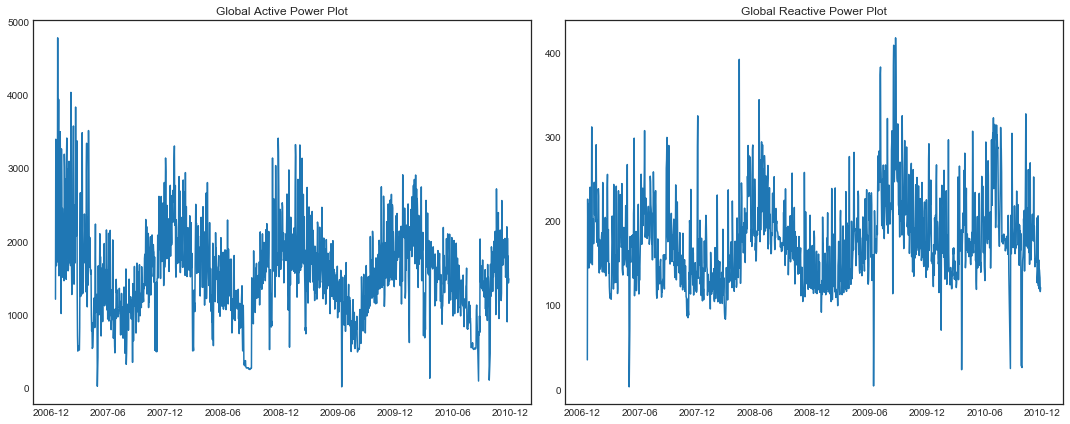

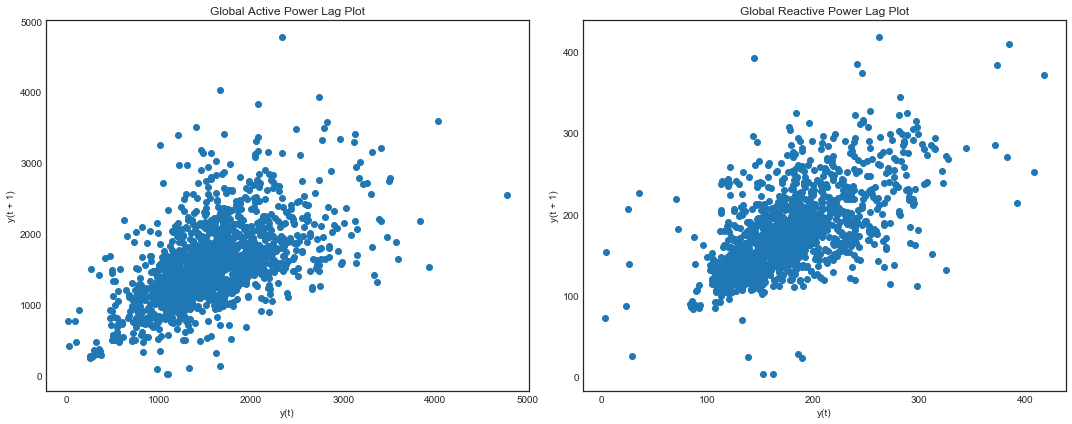

In [29]:
glb_active_pwr   = pd.Series(pwr_consumption.Global_active_power)
glb_reactive_pwr = pd.Series(pwr_consumption.Global_reactive_power)

def time_series_plotting(func, series1, series2):
    """
    takes a 
    """
    fig, ax = plt.subplots(2, figsize=(15,6))

    plt.subplot(121)
    func(series1)
    plt.title('{} {}'.format(series1.name, func.__name__).replace('_', ' ').title())

    plt.subplot(122)
    func(series2)
    plt.title('{} {}'.format(series2.name, func.__name__).replace('_', ' ').title())

    plt.tight_layout()
    plt.show()

time_series_plotting(plt.plot, glb_active_pwr, glb_reactive_pwr)
time_series_plotting(lag_plot, glb_active_pwr, glb_reactive_pwr)

(your description here)

**Part 3**: Fit an autoregressive model to the data, and use it to make predictions over the next 30 days of useage (defined by creating a test set from the last 30 days of available data). Describe your findings. (15 points)

Global_active_power
Lag: 23
Test_Active MSE: 131091.374

Global_reactive_power
Lag: 23
Test_Active MSE: 1397.127


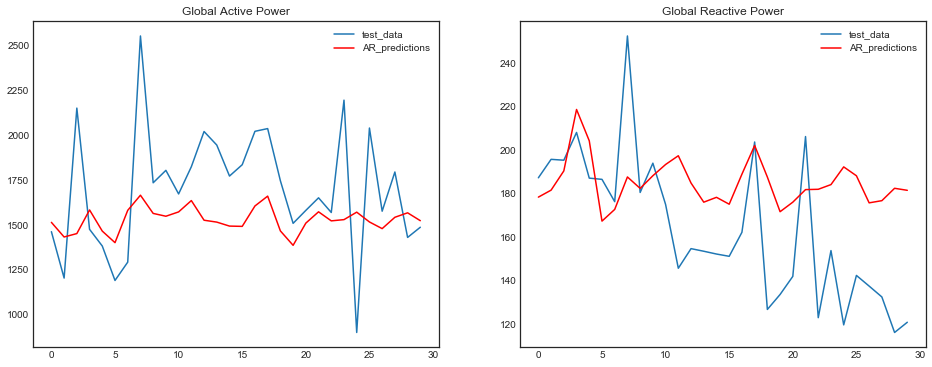

In [30]:
def fit_AR1(series):
    vals = series.values
    train, test = vals[1:len(vals)-30], vals[len(vals)-30:]

    model = AR(train)
    model_fit = model.fit()
    print(series.name)
    print('Lag: %s' % model_fit.k_ar)
    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    for i in range(len(predictions)):
        error = mean_squared_error(test, predictions)
    print('Test_Active MSE: %.3f' % error)
    return test, predictions

t1, p1 = fit_AR1(glb_active_pwr)
print()
t2, p2 = fit_AR1(glb_reactive_pwr)

fig, ax = plt.subplots(2, figsize=(16,6))

plt.subplot(121)
plt.plot(t1, label='test_data')
plt.plot(p1, color='red', label='AR_predictions')
plt.title('Global Active Power')
plt.legend()

plt.subplot(122)
plt.plot(t2, label='test_data')
plt.plot(p2, color='red', label='AR_predictions')
plt.title('Global Reactive Power')
plt.legend()

plt.show()

(your description here)